### **Load libraries**

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Define ticker names**

In [4]:
col_stock_list_path = 'colombia_stocks_trii.csv'
global_stock_list_path = 'global_stocks_trii.csv'

ticker_list_col = list(pd.read_csv(col_stock_list_path, header=None)[0])
ticker_list_glob = list(pd.read_csv(global_stock_list_path, header=None)[0])

### **Extract data from YFinance**

In [5]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 252

In [6]:
days_of_data = 1200 #790
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=days_of_data)

In [7]:
interval = '1d'   # Uncomment for daily data
#interval = '1wk'  # Uncomment for weekly data
# interval = '1mo' # Uncomment for monthly data

col_stocks_raw = yf.download(ticker_list_col, interval=interval, start=start_date, end=end_date, auto_adjust=True)['Close']
global_stocks_raw = yf.download(ticker_list_glob, interval=interval, start=start_date, end=end_date, auto_adjust=True)['Close']

[*********************100%***********************]  37 of 37 completed

3 Failed downloads:
['GXTESCOL.CL', 'NUAMCO.CL', 'LTMCO.CL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2021-10-31 -> 2025-02-12)')
[*********************100%***********************]  49 of 49 completed

7 Failed downloads:
['ICHNA.XD', 'ENELAMCO.CL', 'IWVLM.XD', 'SQMBCO.CL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2021-10-31 -> 2025-02-12)')
['CFMITNIPCO', 'IBO1', 'LTMCO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


### **Preprocessing**

In [8]:
# Assign a frequency to the index of the dataframes
col_stocks_raw.index = col_stocks_raw.index.to_period(freq='D') # Uncomment to set frequency as Daily
global_stocks_raw.index = global_stocks_raw.index.to_period(freq='D') # Uncomment to set ferquency as Daily

# col_stocks_raw.index = col_stocks_raw.index.to_period(freq='W') # Uncomment to set frequency as Weekly
# global_stocks_raw.index = global_stocks_raw.index.to_period(freq='W') # Uncomment to set ferquency as Weekly

# col_stocks_raw.index = col_stocks_raw.index.to_period(freq='M') # Uncomment to set frequency as Monthly
# global_stocks_raw.index = global_stocks_raw.index.to_period(freq='M') # Uncomment to set frequency as Monthly

C:\Users\jumar\AppData\Local\Temp\ipykernel_59912\553269314.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  col_stocks_raw.index = col_stocks_raw.index.to_period(freq='D') # Uncomment to set frequency as Daily
C:\Users\jumar\AppData\Local\Temp\ipykernel_59912\553269314.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  global_stocks_raw.index = global_stocks_raw.index.to_period(freq='D') # Uncomment to set ferquency as Daily


In [9]:
# Convert from prices into returns
col_rets_raw = col_stocks_raw.pct_change().iloc[1:]
global_rets_raw = global_stocks_raw.pct_change().iloc[1:]

C:\Users\jumar\AppData\Local\Temp\ipykernel_59912\959564986.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  col_rets_raw = col_stocks_raw.pct_change().iloc[1:]
C:\Users\jumar\AppData\Local\Temp\ipykernel_59912\959564986.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  global_rets_raw = global_stocks_raw.pct_change().iloc[1:]


In [10]:
# Define start and end dates of the analysis
days_of_analysis = 260*4   # Daily, 2 years
# days_of_analysis = 7*108   # Weekly, 2 years
end_date = str(datetime.date.today())
start_date = str(datetime.date.today() - datetime.timedelta(days=days_of_analysis))

In [11]:
# Merge Col and Global stock prices and returns data
rets = pd.concat([col_rets_raw, global_rets_raw], axis='columns').sort_index()
stocks = pd.concat([col_stocks_raw, global_stocks_raw], axis='columns').sort_index()
stocks = stocks.loc[:, rets.columns]

In [12]:
rets = rets.loc[start_date:end_date]
stocks = stocks.loc[start_date:end_date]

In [13]:
stocks_not_missing = stocks.columns[stocks.isna().sum() < stocks.shape[0]*.15]

In [14]:
rets = rets[stocks_not_missing].fillna(0)
stocks = stocks[stocks_not_missing].fillna(method='bfill')

C:\Users\jumar\AppData\Local\Temp\ipykernel_59912\2388026509.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stocks = stocks[stocks_not_missing].fillna(method='bfill')


In [15]:
# Generate train, validation and test sets to evaluate the accuracy of the model
# 1st The model will be modeled based on the train data initially
# 2nd The model will be fine tuned based on accuracy results with the validation set
# 3rd it will be evaluated with the test set

train_rets = rets.iloc[:-36].copy()
val_rets = rets.iloc[-24:-12].copy()
test_rets = rets.iloc[-12:].copy()

# **Factor regression to estimate annual returns**

### **Extract data to generate the new factors**

In [16]:
tickers = list(rets.columns.values)

In [17]:
# Extract Market Cap data
market_caps = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    market_caps[ticker] = stock.info.get("marketCap", np.nan)

market_cap_df = pd.Series(market_caps)

In [18]:
pe_ratios = {ticker: yf.Ticker(ticker).info.get("trailingPE", np.nan) for ticker in tickers}
pe_ratios_df = pd.Series(pe_ratios)

# Book-to-market ratio (B/M) is the inverse of P/B ratio
pb_ratios = {ticker: yf.Ticker(ticker).info.get("priceToBook", np.nan) for ticker in tickers}
bm_ratios_df = 1 / pd.Series(pb_ratios)  # Book-to-Market = 1 / Price-to-Book

In [19]:
dividend_yield = {ticker: yf.Ticker(ticker).info.get("dividendYield", np.nan) for ticker in tickers}
dividend_yield_df = pd.Series(dividend_yield)
dividend_yield_df = dividend_yield_df.fillna(0)

In [20]:
ma30 = rk.annualize_returns(train_rets.iloc[-30:-1], periods_per_year=252)#.mean())
ma60_30 = rk.annualize_returns(train_rets.iloc[-60:-30], periods_per_year=252)#.mean())
ma126 = rk.annualize_returns(train_rets.iloc[-126:-1], periods_per_year=252)#.mean())
ma252_126 = rk.annualize_returns(train_rets.iloc[-252:-126], periods_per_year=252)#.mean())
ma252 = rk.annualize_returns(train_rets.iloc[-252:-1], periods_per_year=252)#.mean())

In [22]:
factor_df = pd.DataFrame({
    'Annualized_returns': rk.annualize_returns(train_rets, periods_per_year=252),
    'Annualized_volatility': rk.annualize_vol(train_rets, periods_per_year=252),
    'Market_cap': market_cap_df,
    'PE_ratio': pe_ratios_df,
    'Book_to_market_ratio': bm_ratios_df,
    'Dividend_yield': dividend_yield_df,
    'MA30': ma30,
    'MA60_30': ma60_30,
    'MA126': ma126,
    'MA252_126': ma252_126,
    'MA252': ma252  
})

In [23]:
factor_df = factor_df.loc[factor_df['Market_cap'].isnull() == False]

In [24]:
factor_df.loc[:, ['PE_ratio', 'Book_to_market_ratio']] = factor_df[['PE_ratio', 'Book_to_market_ratio']].fillna({'PE_ratio': factor_df['PE_ratio'].mean(),
                                                        'Book_to_market_ratio': factor_df['Book_to_market_ratio'].mean()})

In [25]:
mins = factor_df.loc[:, ['Market_cap', 'PE_ratio', 'Book_to_market_ratio', 'Dividend_yield']].min()
maxs = factor_df.loc[:, ['Market_cap', 'PE_ratio', 'Book_to_market_ratio', 'Dividend_yield']].max()

factor_df.loc[:, ['Market_cap', 'PE_ratio', 'Book_to_market_ratio', 'Dividend_yield']] = (factor_df.loc[:, ['Market_cap', 'PE_ratio', 'Book_to_market_ratio', 'Dividend_yield']] - mins)/(maxs - mins)

In [26]:
factor_df

,Annualized_returns,Annualized_volatility,Market_cap,PE_ratio,Book_to_market_ratio,Dividend_yield,MA30,MA60_30,MA126,MA252_126,MA252
BCOLOMBIA.CL,0.055258,0.354283,0.503031,0.051114,1.032917e-03,0.273493,0.164453,0.285534,0.216883,0.066671,0.139005
BHI.CL,0.017107,0.393720,0.158068,0.065250,7.568098e-08,0.334793,-0.203189,0.317103,0.027271,0.678740,0.314496
BOGOTA.CL,-0.130088,0.370823,0.124631,0.111179,1.673700e-03,0.179185,-0.131424,-0.098369,0.054121,-0.092409,-0.022176
BVC.CL,0.094569,0.380772,0.008188,0.059286,9.378513e-04,0.331762,-0.103338,-0.075240,-0.279835,0.128367,-0.097744
CELSIA.CL,0.010386,0.307239,0.046789,0.092950,1.053614e-03,0.279219,-0.374076,-0.241278,-0.206007,0.838279,0.210153
CEMARGOS.CL,0.294202,0.393110,0.171293,0.195177,7.217088e-04,0.176490,5.275778,1.764692,0.614159,0.831607,0.719882
CNEC.CL,-0.398069,0.425144,0.004890,0.017605,7.230810e-07,0.950488,4.103500,-0.674982,-0.207341,-0.569503,-0.416555
CONCONCRET.CL,0.130501,0.429070,0.008780,0.379886,2.088344e-03,0.000000,13.919724,1.941079,1.174785,0.147959,0.578042
CORFICOLCF.CL,-0.153311,0.329932,0.077672,0.201919,2.078563e-03,0.099697,-0.357721,4.843403,0.039980,-0.030156,0.004160
ECOPETROL.CL,-0.148363,0.348172,1.000000,0.026043,1.030715e-03,1.000000,0.379714,-0.755201,-0.496935,-0.040923,-0.304500


### **Factor model**

In [34]:
model = sm.OLS(endog=factor_df['MA126'],#factor_df['MA126'],
               exog=sm.add_constant(factor_df).drop(columns=['MA30', 'MA60_30', 'MA126', 'MA252_126', 'MA252'])).fit()

In [35]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  MA126   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     3.779
Date:                Wed, 12 Feb 2025   Prob (F-statistic):            0.00393
Time:                        15:22:13   Log-Likelihood:                -32.734
No. Observations:                  52   AIC:                             79.47
Df Residuals:                      45   BIC:                             93.13
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.34

### **Preprocessing - Analysis of stationarity**

In [284]:
# Analysis of stationarity for the whole series
for stock in rets.columns:
    print(f'Augmented Dickey Fuller Test p-value for non-stationarity of level {stock} series: {round(adfuller(rets[stock].rolling(21).mean().dropna())[1], 4)}')

Augmented Dickey Fuller Test p-value for non-stationarity of level BCOLOMBIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BHI.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BOGOTA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BVC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CELSIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CEMARGOS.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CNEC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CONCONCRET.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CORFICOLCF.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ECOPETROL.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ENKA.CL series: 0.0
Augmented Dicke

In [17]:
# Generate train, validation and test sets to evaluate the accuracy of the model
# 1st The model will be modeled based on the train data initially
# 2nd The model will be fine tuned based on accuracy results with the validation set
# 3rd it will be evaluated with the test set

train_rets = rets.iloc[:-36].copy()
val_rets = rets.iloc[-24:-12].copy()
test_rets = rets.iloc[-12:].copy()

In [18]:
(rets.index.min(), rets.index.max())

(Period('2022-04-07', 'D'), Period('2025-02-07', 'D'))

<Axes: xlabel='Date'>

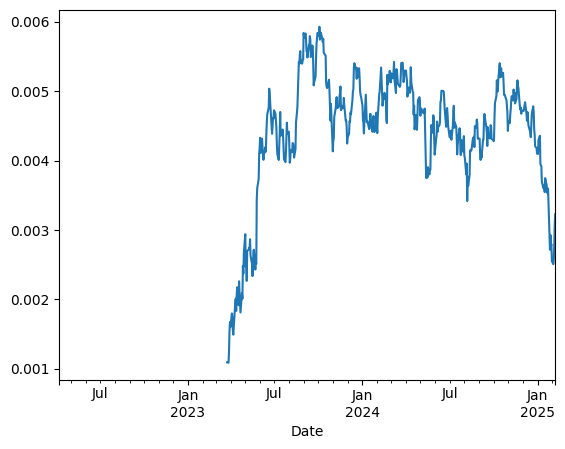

In [287]:
rets['NVDA'].rolling(252).mean().plot()

### **Initial examination**

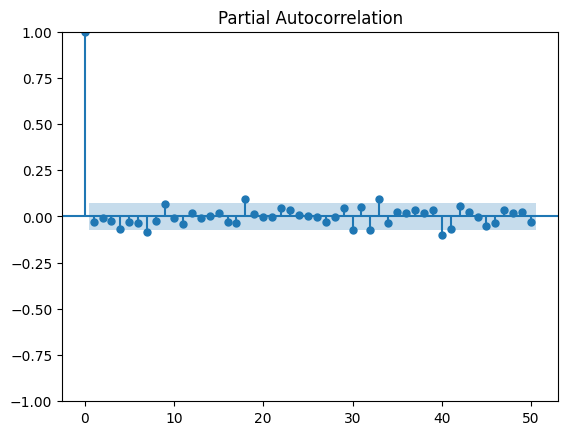

In [19]:
plot_pacf(train_rets['LQDA'], lags=50)
plt.show()

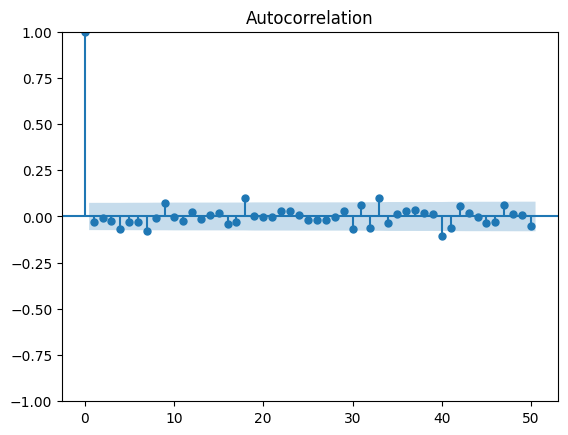

In [20]:
plot_acf(train_rets['LQDA'], lags=50)
plt.show()

### **ARIMA model**

In [65]:
best_nvda = auto_arima(train_rets['NVDA'], min_p=0, max_p=20, min_q=0, max_q=20, out_of_sample_size=20)
best_nvda

ARIMA(order=(0, 0, 0), out_of_sample_size=20, scoring_args={},
      suppress_warnings=True)

In [64]:
best_nvda.predict(20)

array([ 5.23133478e-04, -4.15716191e-03,  2.42104019e-03, -1.53249355e-03,
        4.48601757e-03, -1.27246228e-03,  3.74263584e-03, -8.54464632e-04,
        3.26269300e-03, -3.63298222e-04,  2.85711434e-03,  1.82338702e-05,
        2.53128146e-03,  3.20851174e-04,  2.27921057e-03,  5.59142250e-04,
        2.08445724e-03,  7.46500123e-04,  1.93462663e-03,  8.94184116e-04])

In [70]:
nvda_arima = ARIMA(train_rets['NVDA'], order=(9, 1, 3)).fit()
print(nvda_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                   NVDA   No. Observations:                  706
Model:                 ARIMA(9, 1, 3)   Log Likelihood                1396.313
Date:                Wed, 12 Feb 2025   AIC                          -2766.625
Time:                        15:58:31   BIC                          -2707.369
Sample:                    04-11-2022   HQIC                         -2743.727
                         - 12-23-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7493      0.277     -2.710      0.007      -1.291      -0.207
ar.L2         -0.2590      0.293     -0.884      0.377      -0.834       0.316
ar.L3         -0.0363      0.058     -0.629      0.5

C:\Python projects\Finance\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### **OLS model**

In [75]:
model_df = train_rets[['NVDA']]

In [278]:
def ols_rets(stock, data, window_size=30, num_lag_windows=1, params=['mean']):
    model_df = data[[stock]].copy()
    for i in range(num_lag_windows):
        if 'mean' in params:
            model_df.loc[:, f'MA{window_size}_L{i+1}'] = model_df[stock].shift(1+(i*window_size)).rolling(window_size).mean()
        if 'stddev' in params:
            model_df.loc[:, f'MStdDev{window_size}_L{i+1}'] = model_df[stock].shift(1+(i*window_size)).rolling(window_size).std()
    model_df.dropna(inplace=True)
    model = sm.OLS(endog=model_df[stock],
                   exog=sm.add_constant(model_df).drop(columns=[stock])).fit()
    return model

In [279]:
test_model = ols_rets('NVDA', train_rets, window_size=126, num_lag_windows=2, params=['mean', 'stddev'])
print(test_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   NVDA   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.412
Date:                Mon, 10 Feb 2025   Prob (F-statistic):             0.0484
Time:                        14:37:46   Log-Likelihood:                 941.22
No. Observations:                 454   AIC:                            -1872.
Df Residuals:                     449   BIC:                            -1852.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0568      0.020      2.833

In [280]:
test_model = ols_rets('NVDA', train_rets, window_size=21, num_lag_windows=12, params=['mean', 'stddev'])
print(test_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   NVDA   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     2.715
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           3.12e-05
Time:                        14:37:50   Log-Likelihood:                 968.49
No. Observations:                 454   AIC:                            -1887.
Df Residuals:                     429   BIC:                            -1784.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1777      0.029      6.190

In [281]:
test_model = ols_rets('META', train_rets, window_size=63, num_lag_windows=4, params=['mean', 'stddev'])
print(test_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   META   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7120
Date:                Mon, 10 Feb 2025   Prob (F-statistic):              0.681
Time:                        14:37:53   Log-Likelihood:                 1107.5
No. Observations:                 454   AIC:                            -2197.
Df Residuals:                     445   BIC:                            -2160.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0064      0.012      0.533   

### **Predictions of moving averages**

In [303]:
def ols_rets(stock, data, window_size=30, num_lag_windows=1, params=['mean']):
    model_df = data[[stock]].copy()
    for i in range(num_lag_windows):
        if 'mean' in params:
            model_df.loc[:, f'MA{window_size}_L{i+1}'] = model_df[stock].shift(1+(i*window_size)).rolling(window_size).mean()
        if 'stddev' in params:
            model_df.loc[:, f'MStdDev{window_size}_L{i+1}'] = model_df[stock].shift(1+(i*window_size)).rolling(window_size).std()
    model_df.dropna(inplace=True)
    model = sm.OLS(endog=model_df[f'MA{window_size}_L{1}'],
                   exog=sm.add_constant(model_df).drop(columns=[stock, f'MA{window_size}_L{1}'])).fit()
    return model

In [352]:
model_test = ols_rets('BCOLOMBIA.CL', train_rets, window_size=22, num_lag_windows=5, params=['mean', 'stddev'])
print(model_test.summary())

                            OLS Regression Results                            
Dep. Variable:                MA23_L1   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     37.33
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           2.99e-52
Time:                        15:02:43   Log-Likelihood:                 2577.3
No. Observations:                 591   AIC:                            -5135.
Df Residuals:                     581   BIC:                            -5091.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0002      0.001     -0.315   

In [298]:
test_df = train_rets[['NVDA']].copy()
test_df['EMA21'] = test_df['NVDA'].ewm(21).mean()
test_df['MA21'] = test_df['NVDA'].rolling(21).mean()

test_df.dropna(inplace=True)

In [299]:
model_test_1 = sm.OLS(test_df['NVDA'], sm.add_constant(test_df['EMA21'])).fit()
print(model_test_1.summary())

                            OLS Regression Results                            
Dep. Variable:                   NVDA   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     66.49
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           1.68e-15
Time:                        14:47:51   Log-Likelihood:                 1392.1
No. Observations:                 686   AIC:                            -2780.
Df Residuals:                     684   BIC:                            -2771.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.001     -1.820      0.0

In [300]:
model_test_1 = sm.OLS(test_df['NVDA'].dropna(), sm.add_constant(test_df['MA21'])).fit()
print(model_test_1.summary())

                            OLS Regression Results                            
Dep. Variable:                   NVDA   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     43.12
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           1.02e-10
Time:                        14:47:53   Log-Likelihood:                 1381.3
No. Observations:                 686   AIC:                            -2759.
Df Residuals:                     684   BIC:                            -2749.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.307      0.7

In [160]:
train_rets.columns

Index(['BCOLOMBIA.CL', 'BHI.CL', 'BOGOTA.CL', 'BVC.CL', 'CELSIA.CL',
       'CEMARGOS.CL', 'CNEC.CL', 'CONCONCRET.CL', 'CORFICOLCF.CL',
       'ECOPETROL.CL', 'ENKA.CL', 'ETB.CL', 'EXITO.CL', 'GEB.CL',
       'GRUBOLIVAR.CL', 'GRUPOARGOS.CL', 'GRUPOAVAL.CL', 'GRUPOSURA.CL',
       'HCOLSEL.CL', 'ICOLCAP.CL', 'ISA.CL', 'MINEROS.CL', 'NUTRESA.CL',
       'PFAVAL.CL', 'PFBCOLOM.CL', 'PFCORFICOL.CL', 'PFDAVVNDA.CL',
       'PFGRUPOARG.CL', 'PFGRUPSURA.CL', 'PROMIGAS.CL', 'TERPEL.CL', 'AAPL',
       'AMZN', 'BAC', 'BRK-B', 'C', 'CBU7.L', 'CENCOSUD.SN', 'CHILE.SN',
       'CSPX.L', 'EIMI.L', 'F', 'FALABELLA.SN', 'GE', 'GOOGL', 'ISAC.CL',
       'IUFS.CL', 'IUIT.CL', 'JETS', 'JNJ', 'JPEA.CL', 'JPM', 'LQDA', 'META',
       'NKE', 'NU', 'NVDA', 'PBR', 'PFE', 'RBOT', 'SDHA.CL', 'SGLD.L',
       'SUAS.CL', 'UBER', 'VOO'],
      dtype='object', name='Ticker')

In [21]:
# https://www.youtube.com/watch?v=mm0DA8zgHIs